## Coding attention mechanism
In this chapter **Sebastian** proposes four different implementation of the attention mechanism. The main goal is to aarrive at a compact and efficent implementation of multi-head attention.

**[1]** *Simplified self-attention* - **[2]** *Self-attention* - **[3]** *Causal attention* - **[4]** *Multi-head attention*

Let introduce the concepts of encoder and decoder. Deep neural network are composed by these two different sub-module (already used during RNN period).
In general, encoder's goal is to process the entire input text into a hidden state, which gives a general overview of the internal state of the model and
next the decoder takes in this hidden state to produce the output.

Inspired by Bahdanau attention mechanism, researcher released *transformer architecture* only three years later than RNN.

**Self-attention mechanism** is a mechanism that allows each position in the input sequence to consider the relevancy of, or "attend to", all other positions in the same sequence when computing the representation of a sequence. Self-attention is a key component of contemporary LLMs based on the transformer architecture, such as the GPT series.



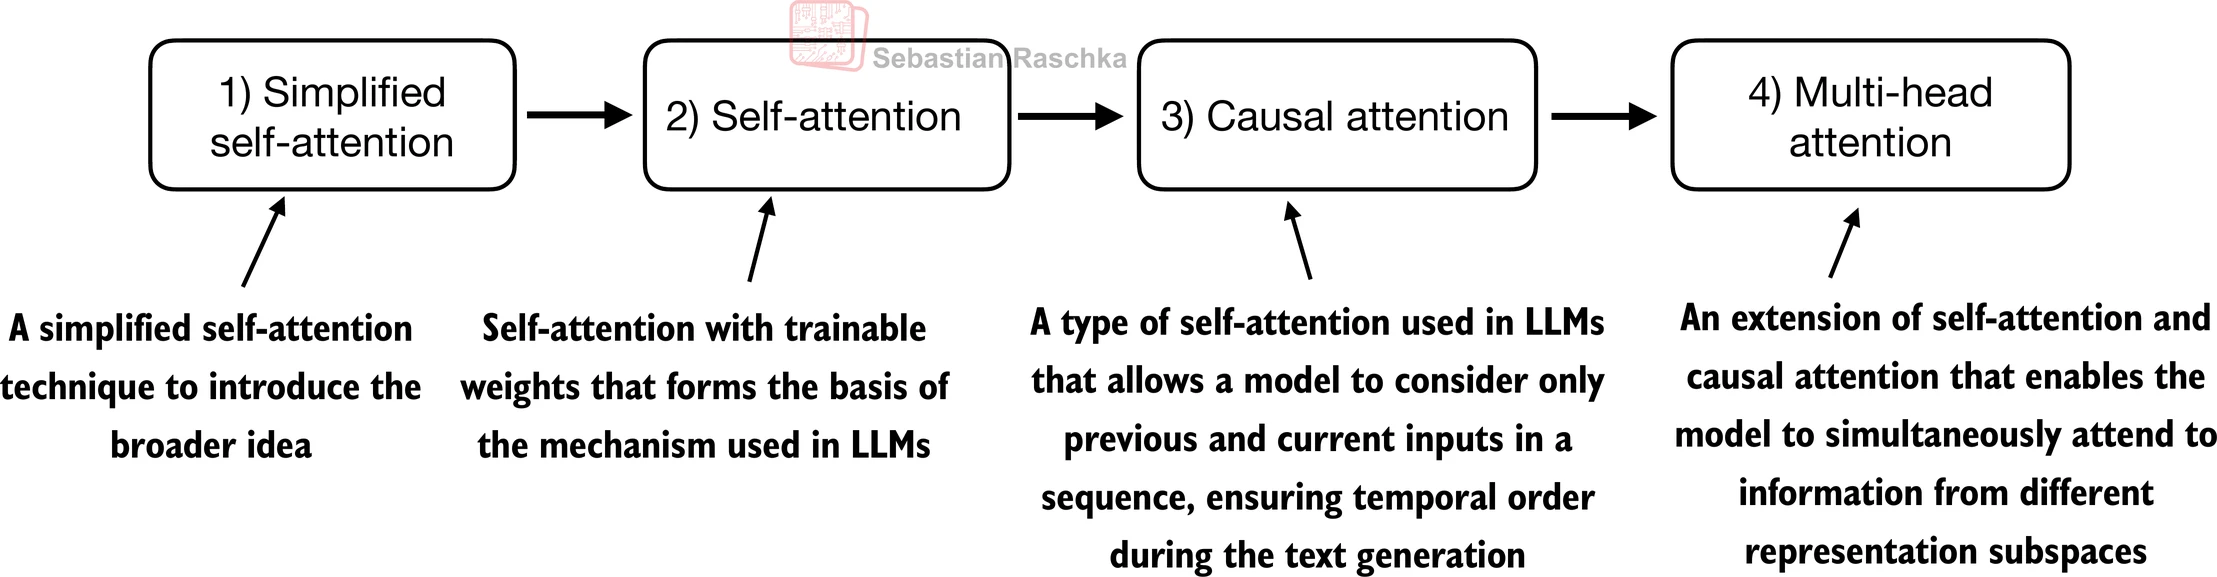

##### Explanation
In self-attention, the "self" refers to the mechanism's ability to compute attention weights by relating different positions within a single input sequence.It assesses and learns the relationships and dependencies between various parts of the input itself, such as words in a sentence or pixels in a image.

The expected output are context vectors for each input element that combines information from all other input elements weighted with respect to input element.

**Context vectors** play a crucial role in self-attention. Their purpose is to create **enriched** representation of each element in an input sequence by incorporating infromation from all other elements in the sequences.

In [2]:
from importlib.metadata import version
print("torch version:", version("torch"))

torch version: 2.9.0


#### Simplified self-attention

In [3]:
import torch

# rows = samples
# columns = features

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

d:\ACER\Documents\LLM-Scratch\.venv\lib\site-packages\torch\_subclasses\functional_tensor.py:279: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [4]:
query = inputs[1]  # 2nd input token is the query

# computing attention weight a_2i with i from 0 to T.
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

"""
Dot-product come from the multiplication of two vectors elements-wise and summing the resulting products.

    SCRATCH IMPLEMENTATION
    for idx, element in enumerate(inputs[0]):
        res += inputs[0][idx] * query[idx]

NOTE: This operation is a mathematical tool used to measure the similarity because it quantifies how closely two vectors are aligned. 
"""

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [5]:
# To ensuring stability during training phases, normalization is required.

# Raw method
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

# Softmax method (numerical issues can happaned creating instability)
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

# NOTE: softmax ensures positive numbers, making easier to interpretate the attention weights as probabilities or relative importance.

# Softmax optimized
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [6]:
# Now we can compute the context vector z^2 
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


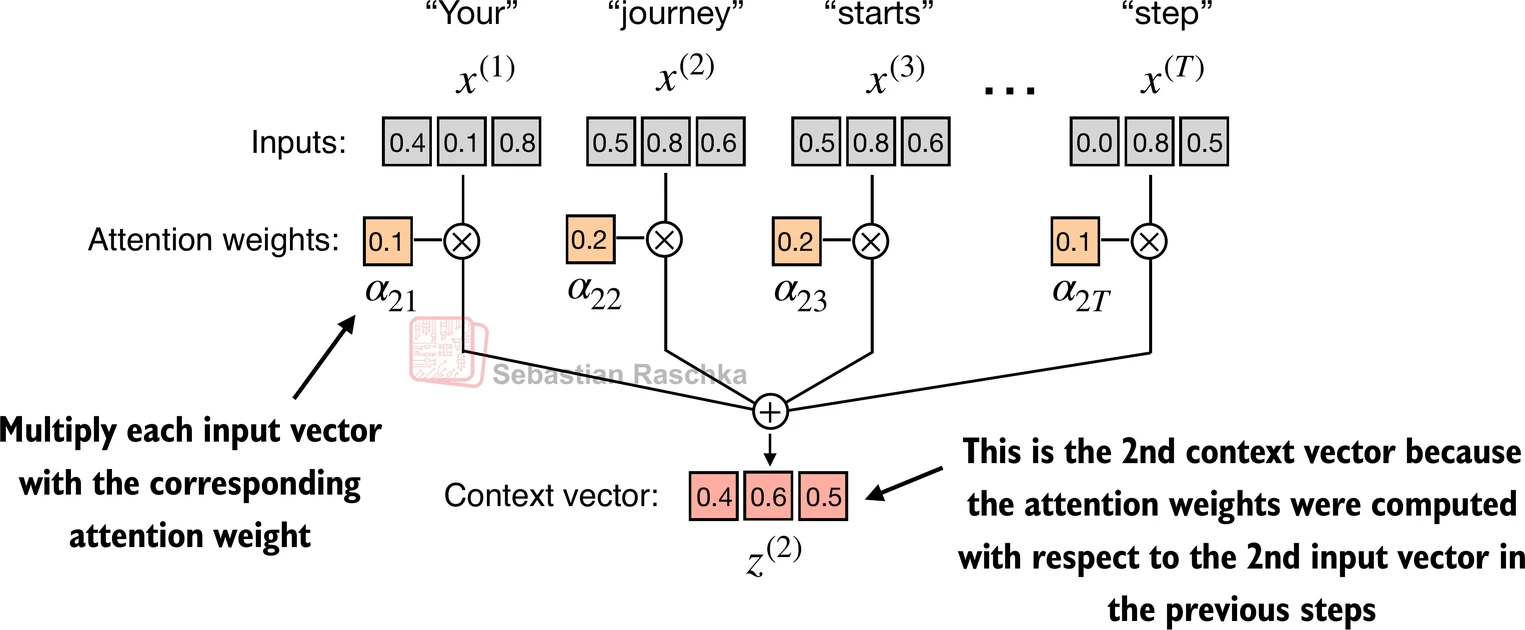

##### Computing attention weights for all input tokens

Now we will generalize the computation to obtain all other attention weights.

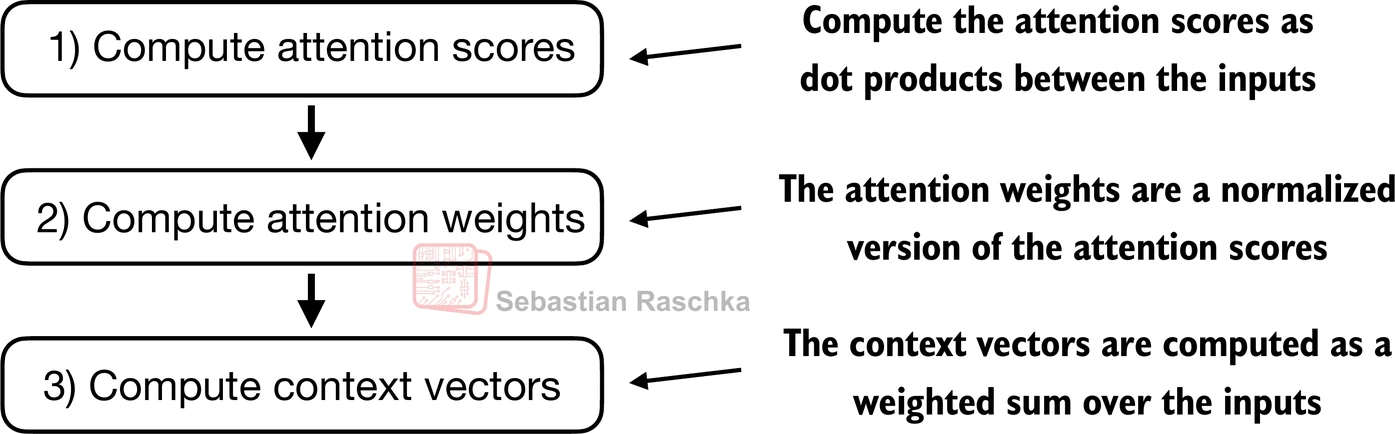

In [7]:
# 1. Pairwise elements to compute unnormalized attention score matrix
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(f"Attention score 1 : {attn_scores}")

# More efficient way using matrix moltiplication

attn_scores = inputs @ inputs.T
print(f"Attention score 2 : {attn_scores}")

# 2. Normalize each row
attn_weights = torch.softmax(attn_scores, dim=-1)  # dim = -1 to normalize along the last dimension
print(f"Attention weight: {attn_weights}")

# 3. Compute all context vectors

all_context_vecs = attn_weights @ inputs
print(all_context_vecs)
print(f"Context vectors: {all_context_vecs}")

Attention score 1 : tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
Attention score 2 : tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
Attention weight: tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1

#### Self-attention with trainable weights

Implementing the scaled dot-product attention. The differents respect the previous implementation is the introduction of weight matrices that are updated during the training phase.

The terms "key", "query" and "value" are borrowed from the domain of database. 
- Query is used to probe the other parts of the input sequence to determine how much attention to pay to them.
- Key is used for indexing and searching. These key are used to match query.
- Value rapresents the actual content or representation of the input items. 

Model determines which keys are most relevant to the query, it retrives the corrisponding values.

In [8]:
# Step by step

# 1. Introducing the three trainable weight matrices W_q, W_k, and W_v. 
'''
This matrices are used to project the embedded input tokens, x^(i), into query, key, and value vectors.
    - Query vector:   q^(i) = x^(i) * W_q
    - Key vector:     k^(i) = x^(i) * W_k
    - Value vector:   v^(i) = x^(i) * W_v
'''
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

# 2. Init three matrices

torch.manual_seed(123)

# ATTENTION: requires_grad is set to False reducing clutter in the output. If we were to use the weight matrices for model training, we would set requires_grad=True to update these matrices during model training
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

# 3. Compute Q, K, V
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print(query_2)

# 4. Generalizing
keys = inputs @ W_key 
values = inputs @ W_value

print("We successfully projected the six input tokens from a three-dimension space onto a two-dimension embedding space.\n")
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

tensor([0.4306, 1.4551])
We successfully projected the six input tokens from a three-dimension space onto a two-dimension embedding space.

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


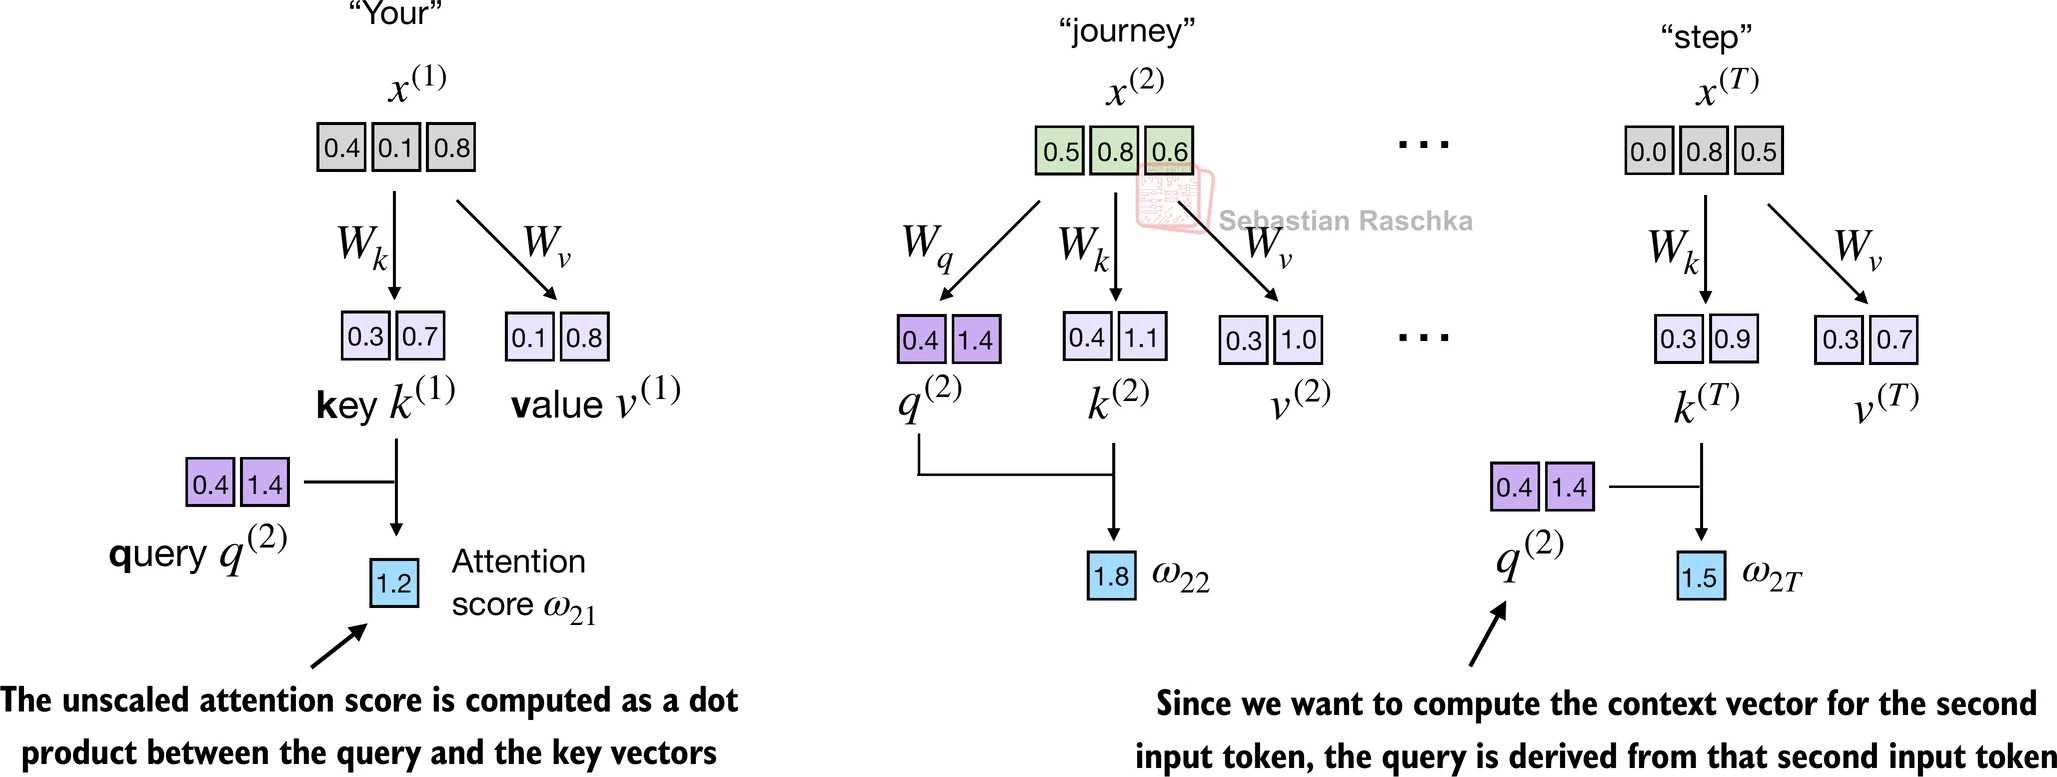

In [9]:
# Computing the attention score Omega_22

keys_2 = keys[1] # Python starts index at 0
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [10]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query (used to compute context vector 2)
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


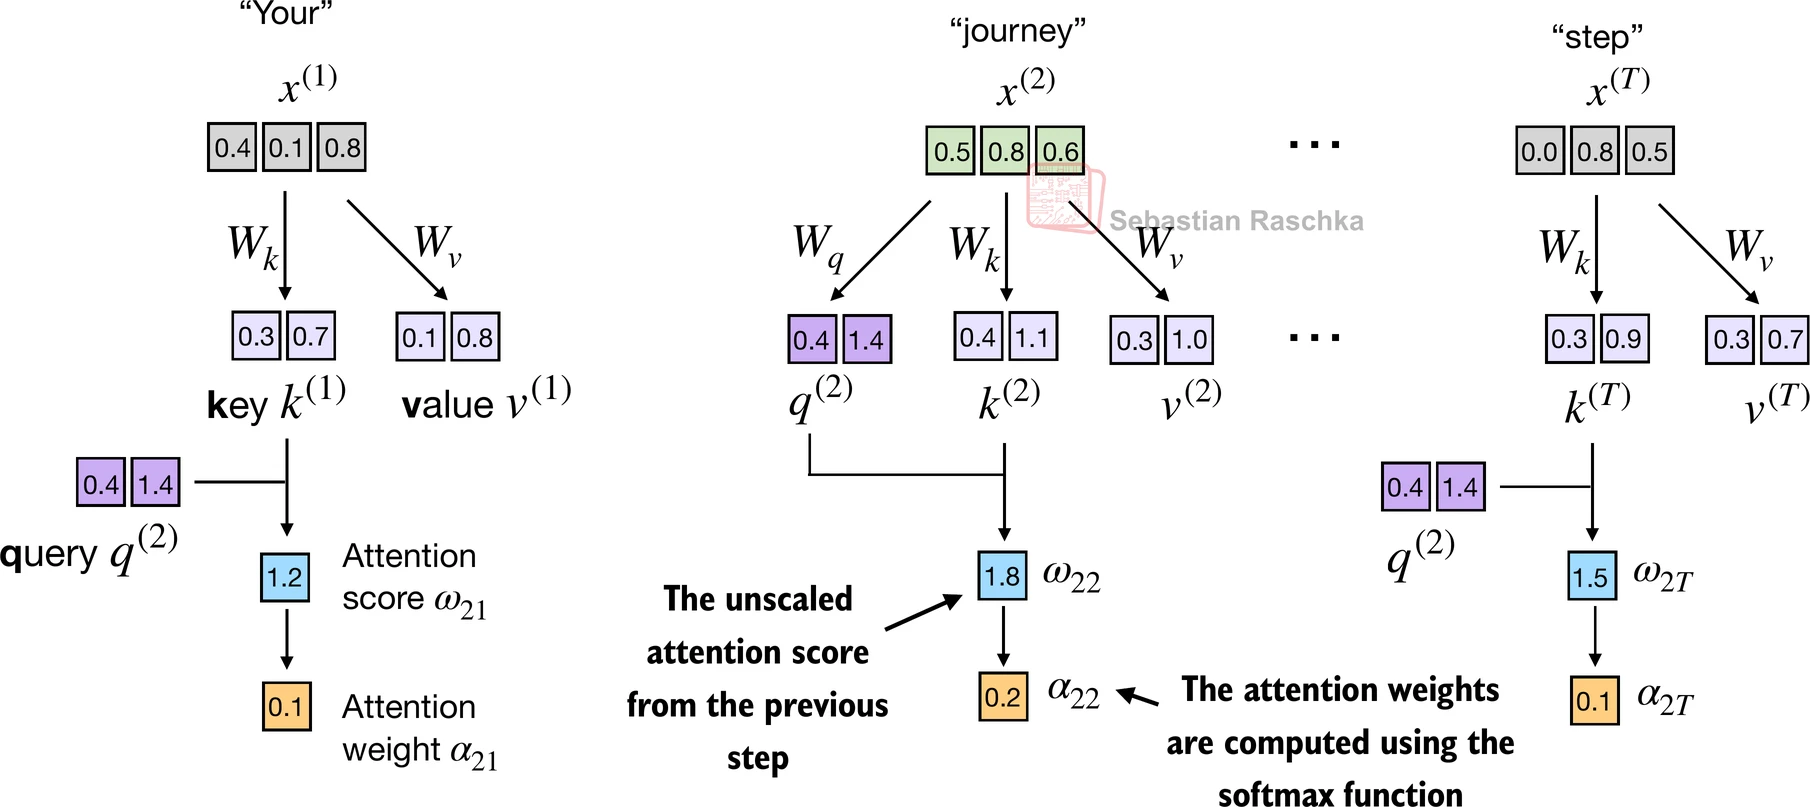

In [11]:
d_k = keys.shape[1]
# Computing the attention weight scaling the attention score and dividing them by the square root of the embedding dimension (done to avoid vanish gradient issues coming from small gradients. These can drastically slow down learning or cause training to stagnate). 
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


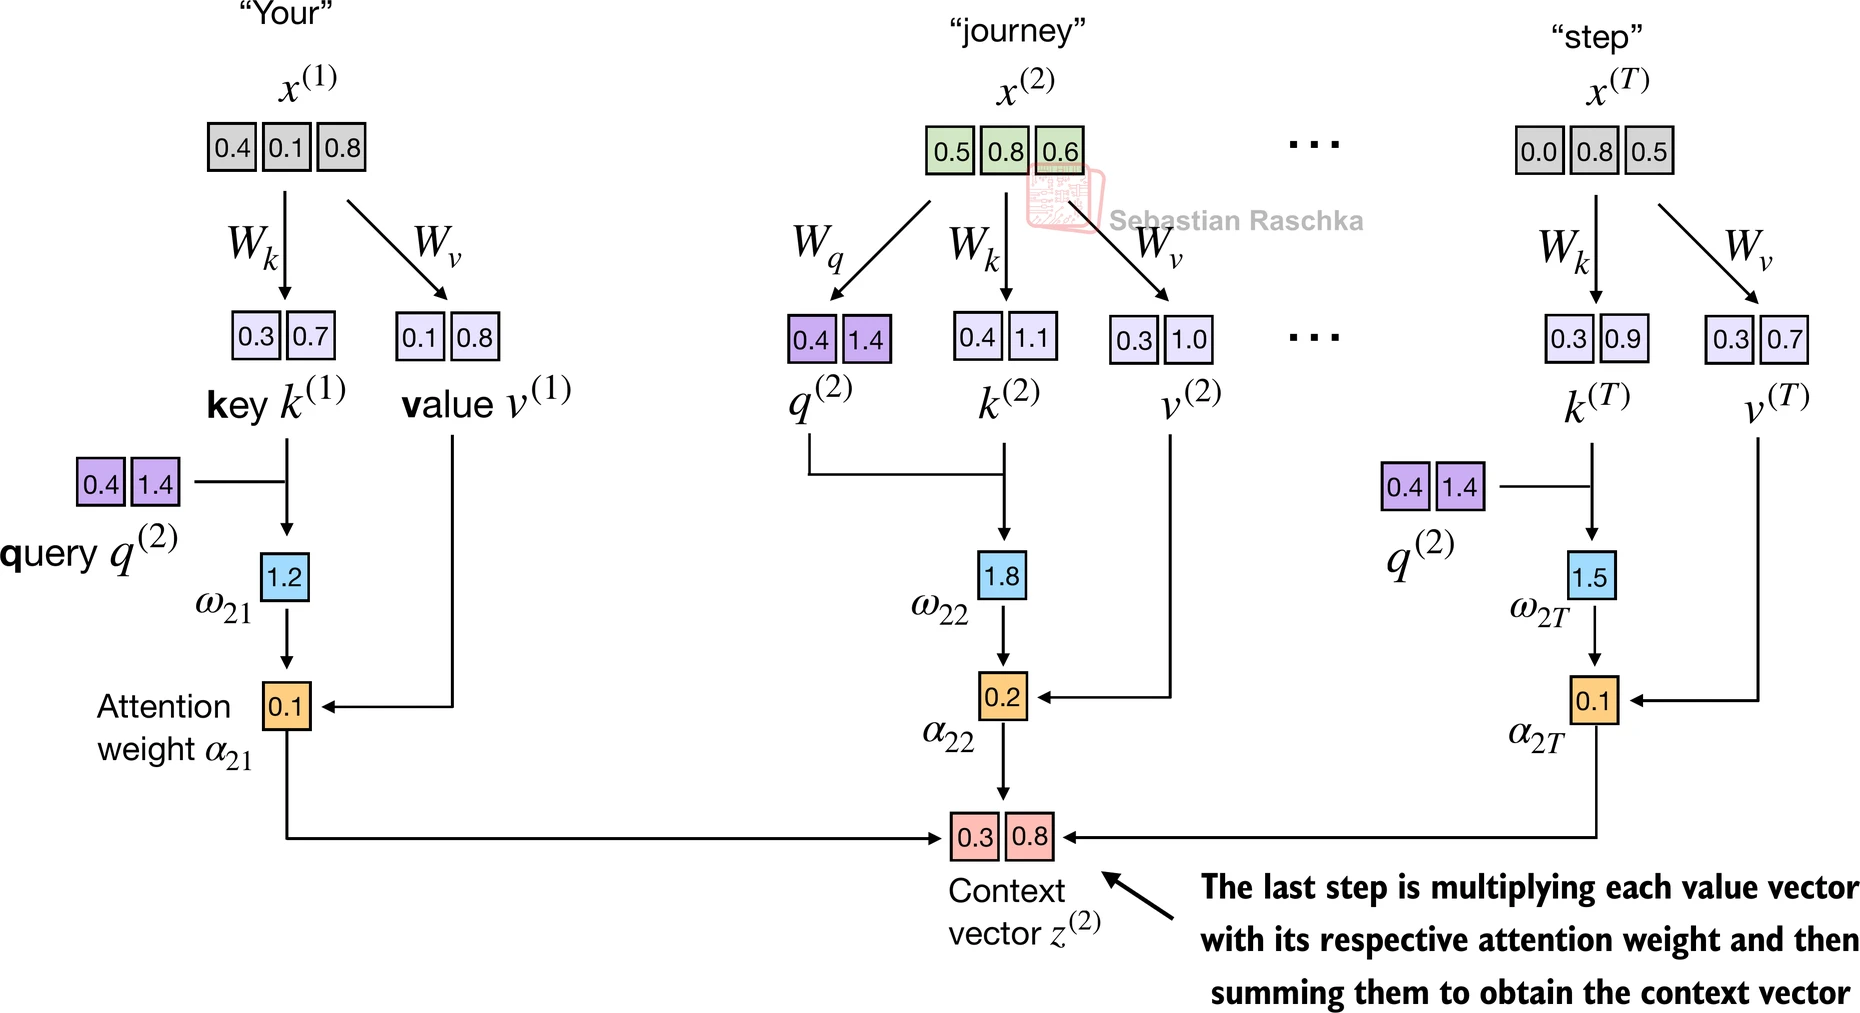

In [12]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


#### Self-Attention Class implementation

In [13]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out, *args, **kwargs):
        super().__init__(*args, **kwargs) 
        # init trainable weight matrices W_q, W_k, and W_v using torch.
        self.W_query = nn.Parameter(torch.randn(d_in, d_out))
        self.W_key = nn.Parameter(torch.randn(d_in, d_out))
        self.W_value = nn.Parameter(torch.randn(d_in, d_out))

    def forward(self, x):
        # given an input x, we can compute q_q, q_k and q_v vectors.
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        # computing the similarity
        attn_scores = queries @ keys.T # omega

        # computing the attention weights, normalizing and apllying softmax 
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim = -1)

        # Now we can compute the context vector by weighting the values with these normalized attention scores.
        context_vec = attn_weights @ values
        
        return context_vec

In [14]:
# Using the Class
torch.manual_seed(123)
SelfAttentionClass = SelfAttention_v1(d_in=3, d_out=2)
print(SelfAttentionClass(inputs))

tensor([[0.2845, 0.4071],
        [0.2854, 0.4081],
        [0.2854, 0.4075],
        [0.2864, 0.3974],
        [0.2863, 0.3910],
        [0.2860, 0.4039]], grad_fn=<MmBackward0>)


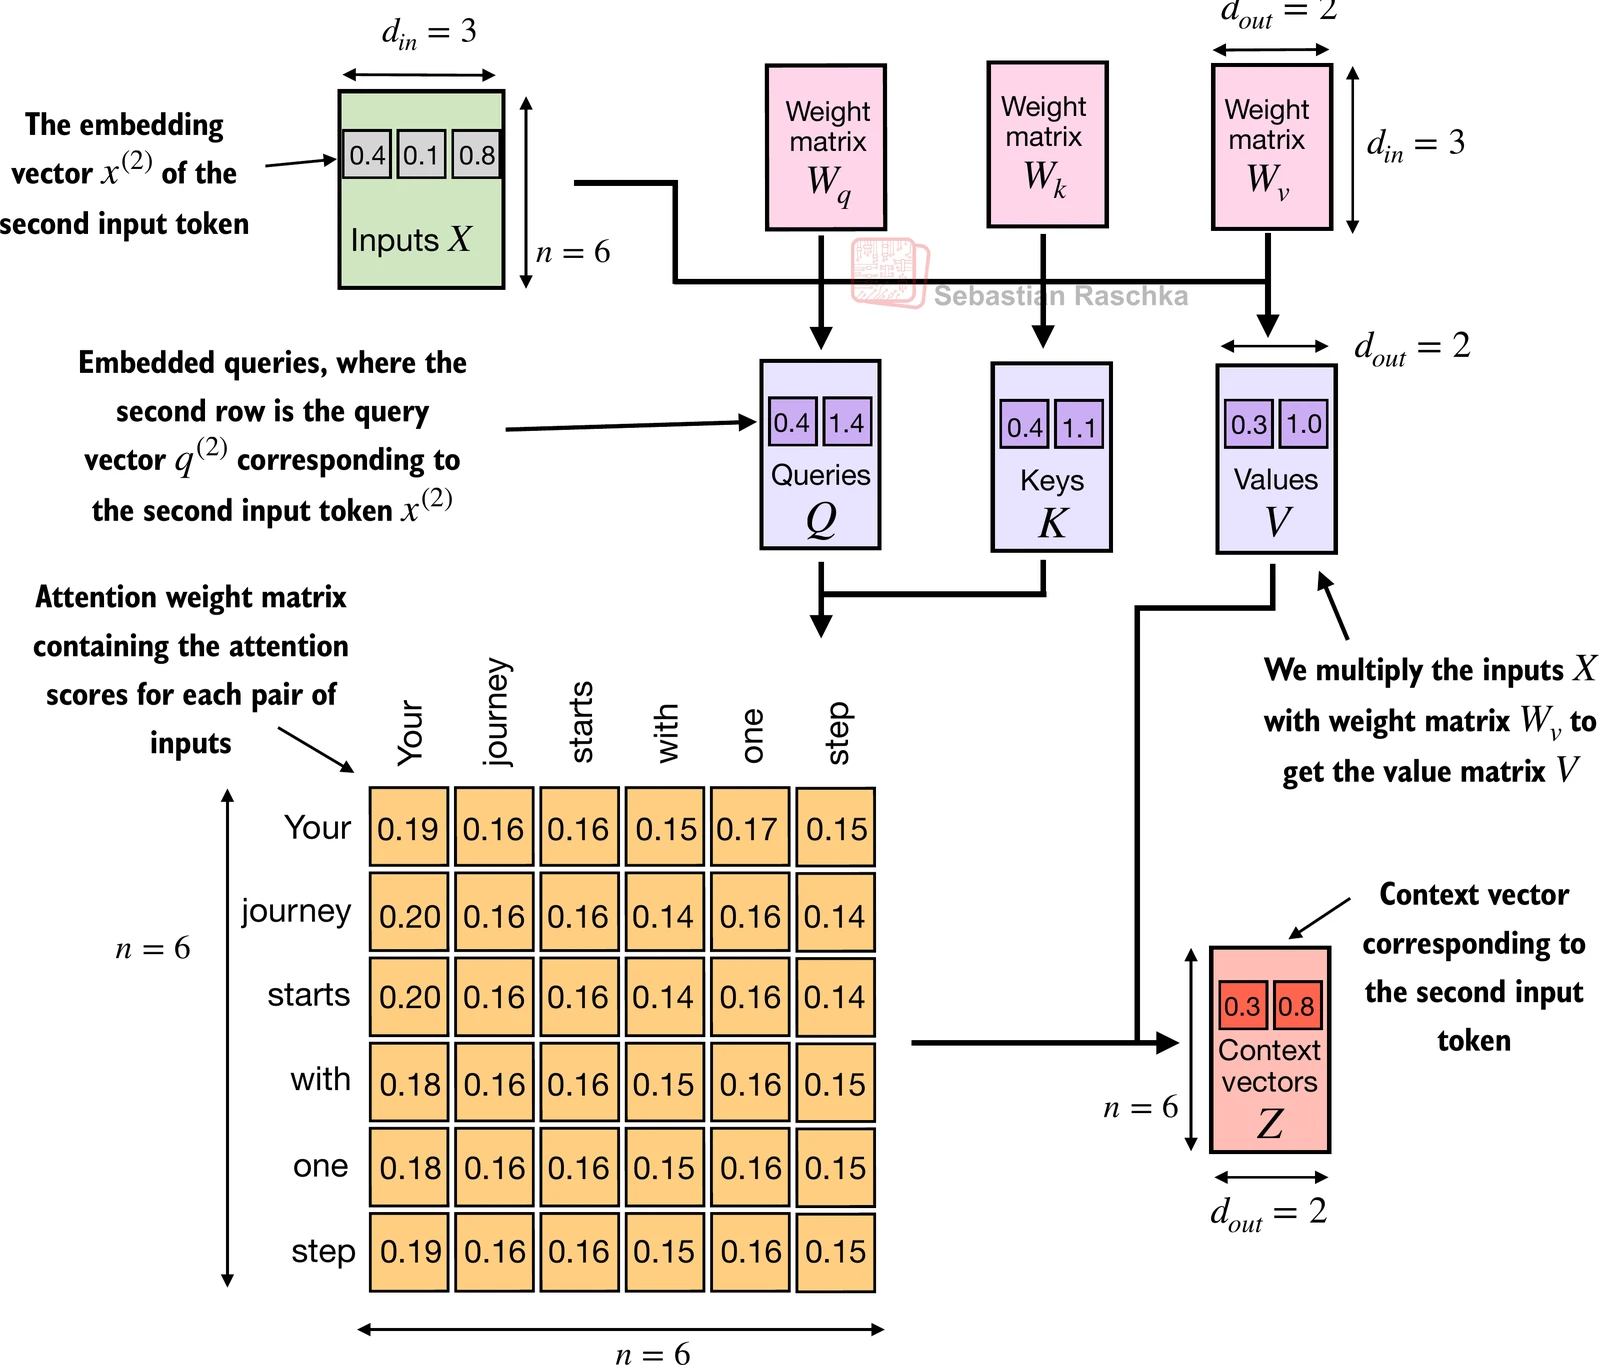

#### Self-Attention Class implementation (using nn.Linear)

This second implementation uses PyTorch's *nn.Linear* layers, which performe matrices multiplication when the bias units are disabled.
In addition, *nn.Linear* has an optimized weight initialization scheme, contributing to more stable and effective model training.

In [15]:
import torch.nn as nn 

class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias = False, *args, **kwargs):
        super().__init__(*args, **kwargs) 
        '''nn.Linear uses a more sophisticated weight initialization scheme'''
        self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)

    def forward(self, x):
        # given an input x, we can compute q_q, q_k and q_v vectors.
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # computing the similarity
        attn_scores = queries @ keys.T # omega

        # computing the attention weights, normalizing and apllying softmax 
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim = -1)

        # Now we can compute the context vector by weighting the values with these normalized attention scores.
        context_vec = attn_weights @ values
        
        return context_vec

#### Exercise 3.1 comparing selfattention_v1 and selfattention_v2

#### Causal Self-Attention 

Also known as **Masked Attention**, is a sepcialized form which restricts the model to only consider previous and current inputs in sequence when proceswsing any given token when computing attention scores.
This impplementation is a little different respect the previous version, changes are made in such way the future tokens are masked. 

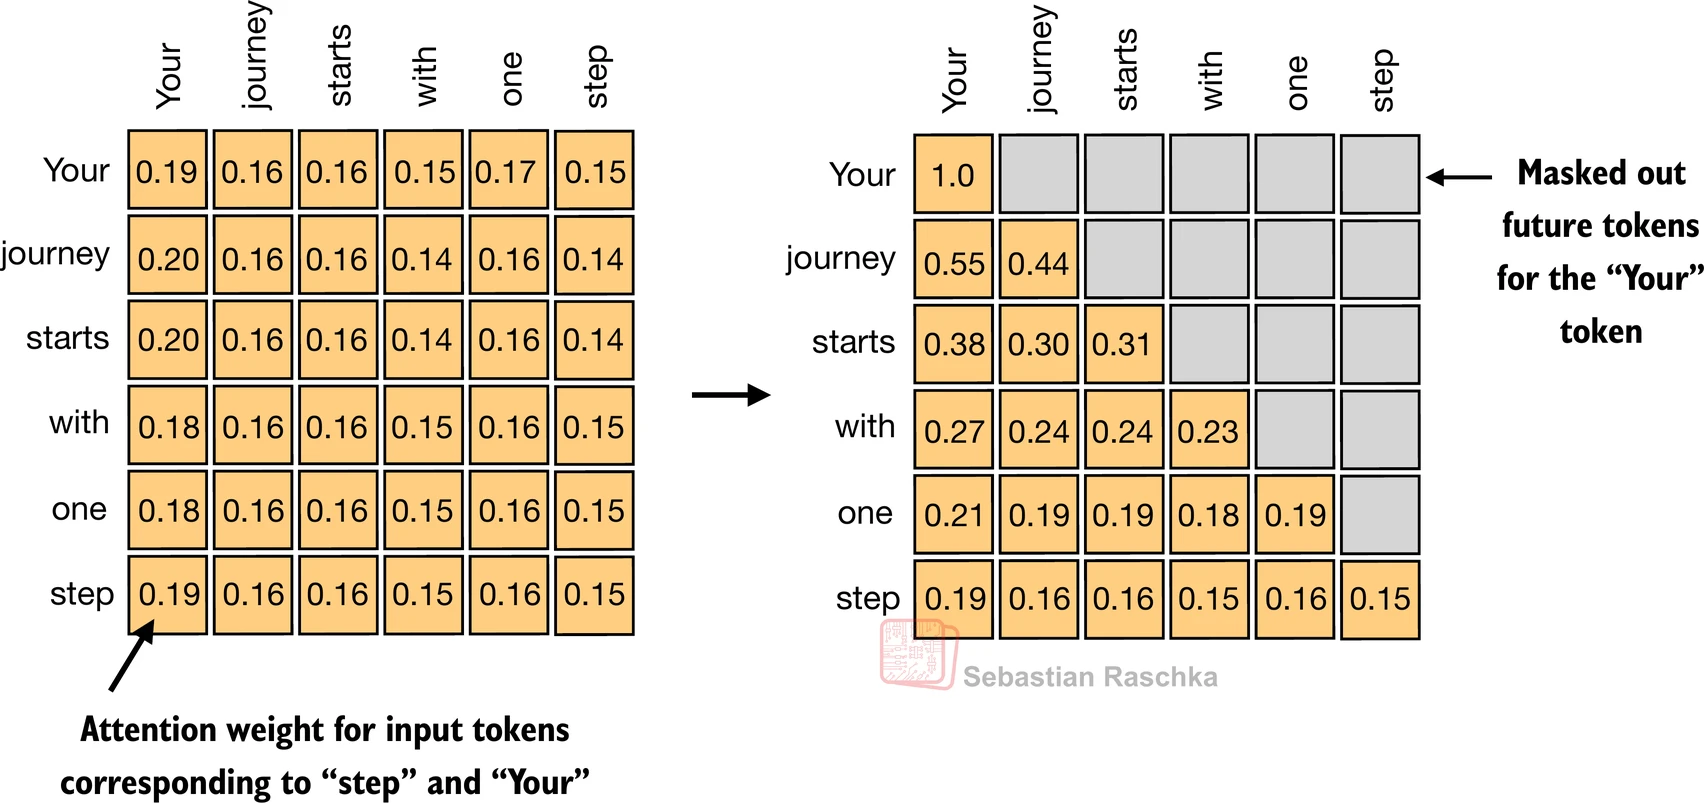

How to get this implementation? 

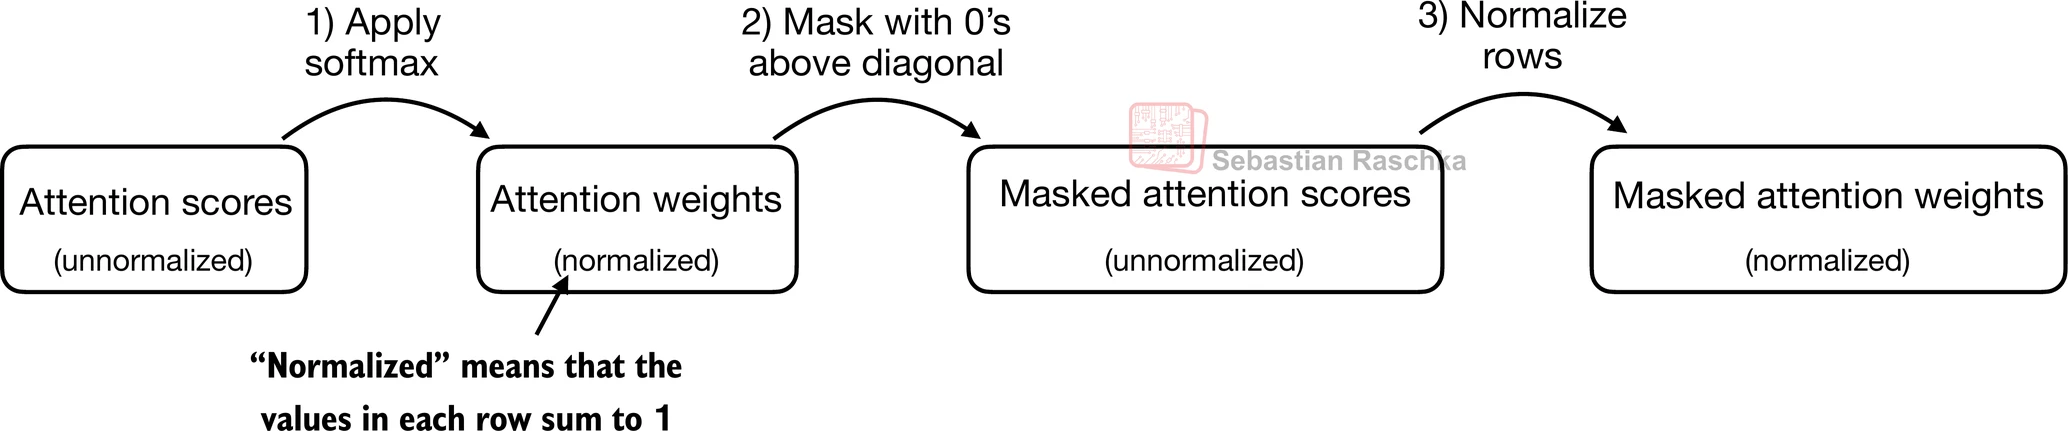



In [16]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience
sa_v2 = SelfAttention_v2(d_in, d_out)
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs) 
attn_scores = queries @ keys.T

# 1. Apply softmax
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

# 2. Mask with 0's above diagonal
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones((context_length, context_length)))
# mask simple is a matrix with 1's in the lower triangle and 0's in the upper triangle
print(mask_simple)

# 3. Apply the mask to the attention scores
masked_simple = attn_weights*mask_simple
print(masked_simple)

# 4. Re-normalize the masked attention scores
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

'''
In this pipeline, the distribution of attention weights is as if it was calculated only among the unmasked positions to begin with.
This ensures there is no information leakage from future tokens.
'''

tensor([[0.1825, 0.1568, 0.1576, 0.1657, 0.1796, 0.1577],
        [0.1852, 0.1554, 0.1562, 0.1655, 0.1814, 0.1563],
        [0.1852, 0.1554, 0.1562, 0.1654, 0.1814, 0.1563],
        [0.1756, 0.1611, 0.1615, 0.1662, 0.1740, 0.1616],
        [0.1804, 0.1589, 0.1594, 0.1655, 0.1765, 0.1593],
        [0.1760, 0.1605, 0.1610, 0.1664, 0.1749, 0.1612]],
       grad_fn=<SoftmaxBackward0>)
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
tensor([[0.1825, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1852, 0.1554, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1852, 0.1554, 0.1562, 0.0000, 0.0000, 0.0000],
        [0.1756, 0.1611, 0.1615, 0.1662, 0.0000, 0.0000],
        [0.1804, 0.1589, 0.1594, 0.1655, 0.1765, 0.0000],
        [0.1760, 0.1605, 0.1610, 0.1664, 0.1749, 0.1612]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.0000

'\nIn this pipeline, the distribution of attention weights is as if it was calculated only among the unmasked positions to begin with.\nThis ensures there is no information leakage from future tokens.\n'

Let's briefly look at a more efficient approach to achieve the same as above. So, instead of zeroing out attention weights above the diagonal and renormalizing the results, we can mask the unnormalized attention scores above the diagonal with negative infinity before they enter the softmax function.

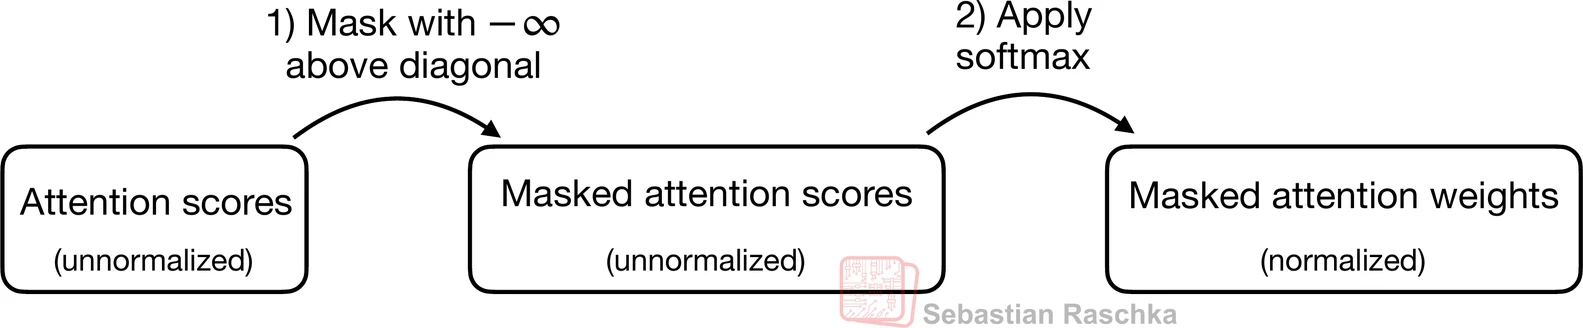

In [17]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[-0.0320,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0337, -0.2816,    -inf,    -inf,    -inf,    -inf],
        [-0.0330, -0.2810, -0.2736,    -inf,    -inf,    -inf],
        [-0.0181, -0.1395, -0.1358, -0.0953,    -inf,    -inf],
        [-0.0108, -0.1907, -0.1857, -0.1326, -0.0421,    -inf],
        [-0.0263, -0.1566, -0.1524, -0.1060, -0.0351, -0.1506]],
       grad_fn=<MaskedFillBackward0>)


In [18]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5437, 0.4563, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3728, 0.3128, 0.3144, 0.0000, 0.0000, 0.0000],
        [0.2642, 0.2425, 0.2431, 0.2502, 0.0000, 0.0000],
        [0.2146, 0.1890, 0.1896, 0.1969, 0.2099, 0.0000],
        [0.1760, 0.1605, 0.1610, 0.1664, 0.1749, 0.1612]],
       grad_fn=<SoftmaxBackward0>)


#### Causal Self-Attention with dropout

Dropout in deep learning is a technique to prevent overfitting. In this method, some randomly selected hidden layer units are ignored. Dropout is only used during training and is disabled afterward.  
To compensate for the reduction in actigve elements, the values are scaled by a factor of 2.

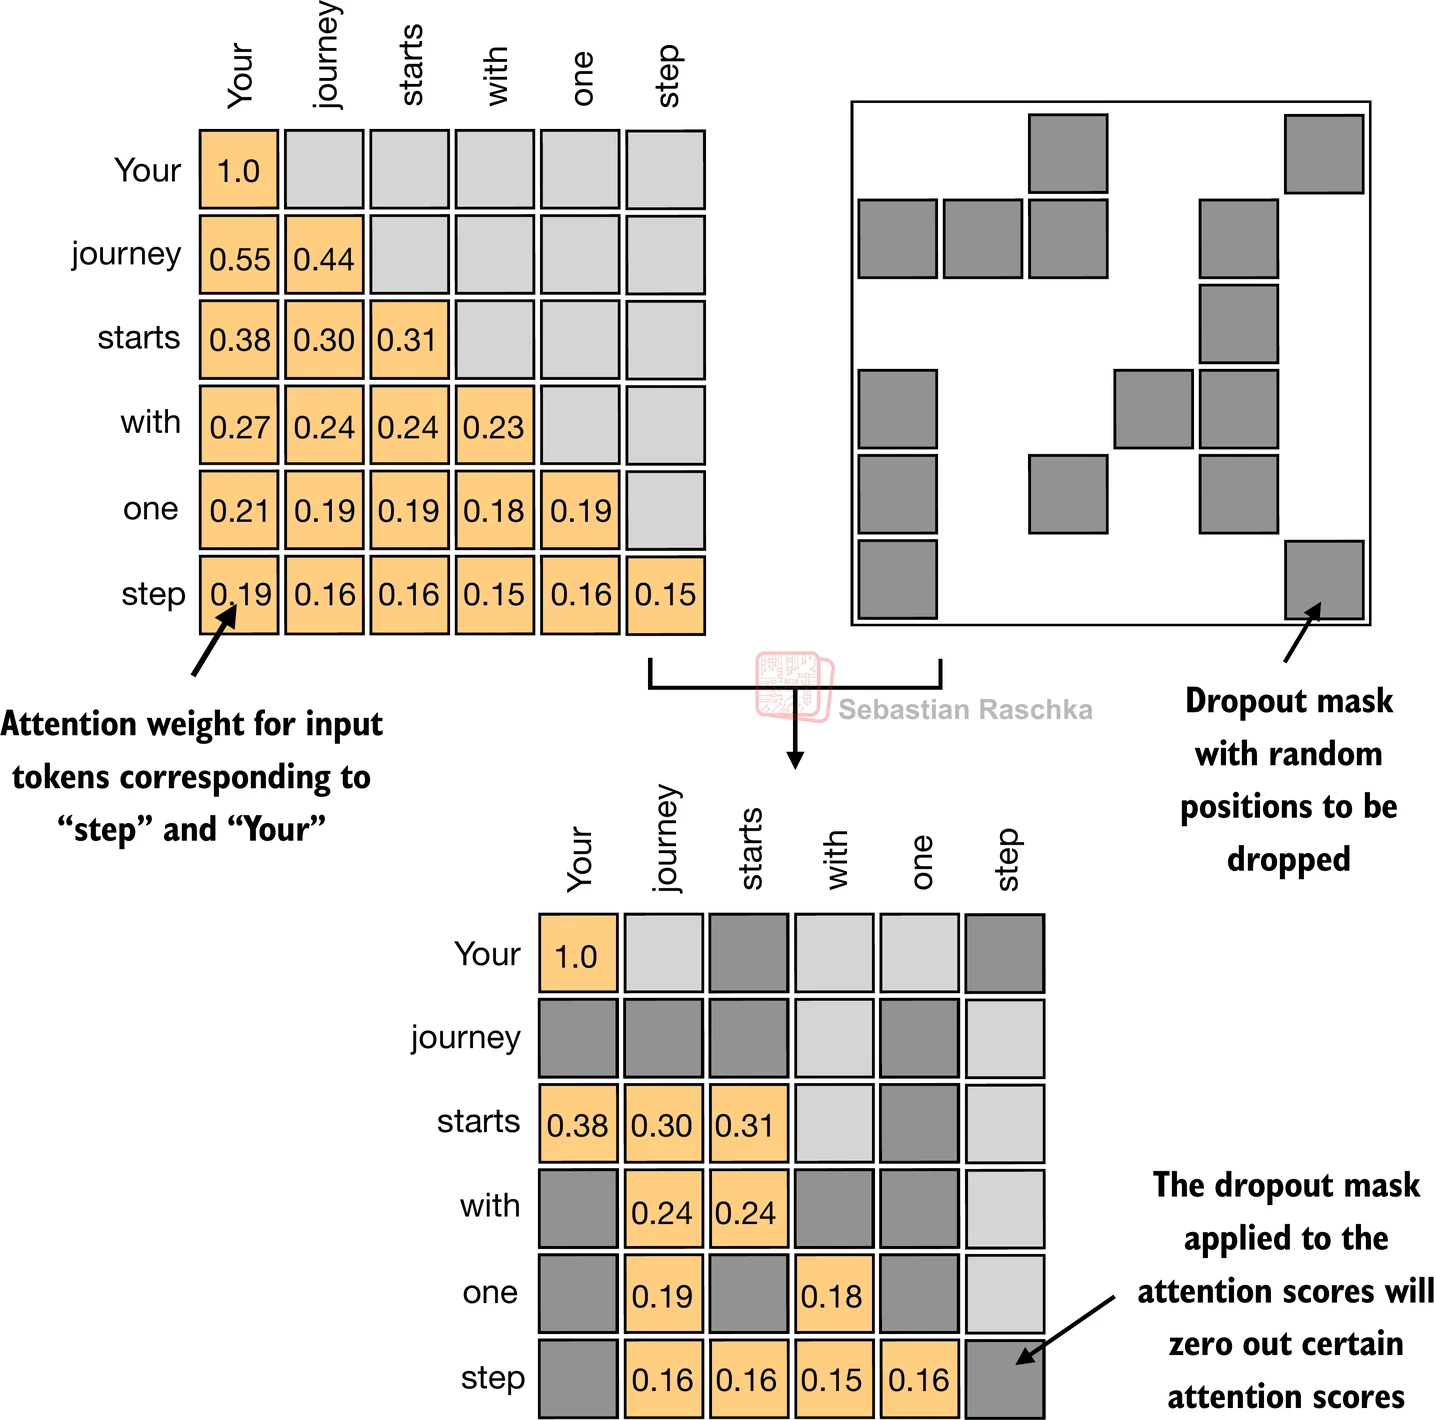

In [19]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [20]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7455, 0.6256, 0.6289, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4850, 0.4862, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3779, 0.0000, 0.3938, 0.0000, 0.0000],
        [0.0000, 0.3210, 0.3220, 0.3327, 0.3498, 0.0000]],
       grad_fn=<MulBackward0>)


#### Causal Attention Class Implementation  

This implementation will include causal and dropout masks. Multiple batches will be accepted by the class.

In [21]:
# Duplicate the inputs
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3


torch.Size([2, 6, 3])


In [22]:
import torch.nn as nn 

class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Dropout layer
        self.dropout = nn.Dropout(dropout) 
        # Creating the causal mask
        # register buffer to ensure the mask is moved to the appropriate device (CPU or GPU) along with the model parameters.
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) 

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        # For inputs where `num_tokens` exceeds `context_length`, this will result in errors
        # in the mask creation further below.
        # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs  
        # do not exceed `context_length` before reaching this forward method. 

        # compute q_q, q_k and q_v vectors.
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # nota: typical shapes: queries, keys, values ∈ (b, T, d) where b=batch, T=num_tokens, d=d_out.
         
        # we transpose dimension 1 and 2, keeping the batch dimension at the first position.
        attn_scores = queries @ keys.transpose(1, 2) 
        attn_scores.masked_fill_(  # New, _ ops are in-place, avoiding unnecessary memory copies
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        # preventing overfitting
        attn_weights = self.dropout(attn_weights) 

        context_vec = attn_weights @ values
        return context_vec

In [23]:
torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


#### Multi-head attention

The term "multi-head" refers to dividing the attention mechanism into multiple "heads", each operating independently.
In that way, the system could be able to handle multi-head attention, where there are a set of attention weights processing the input sequentially.

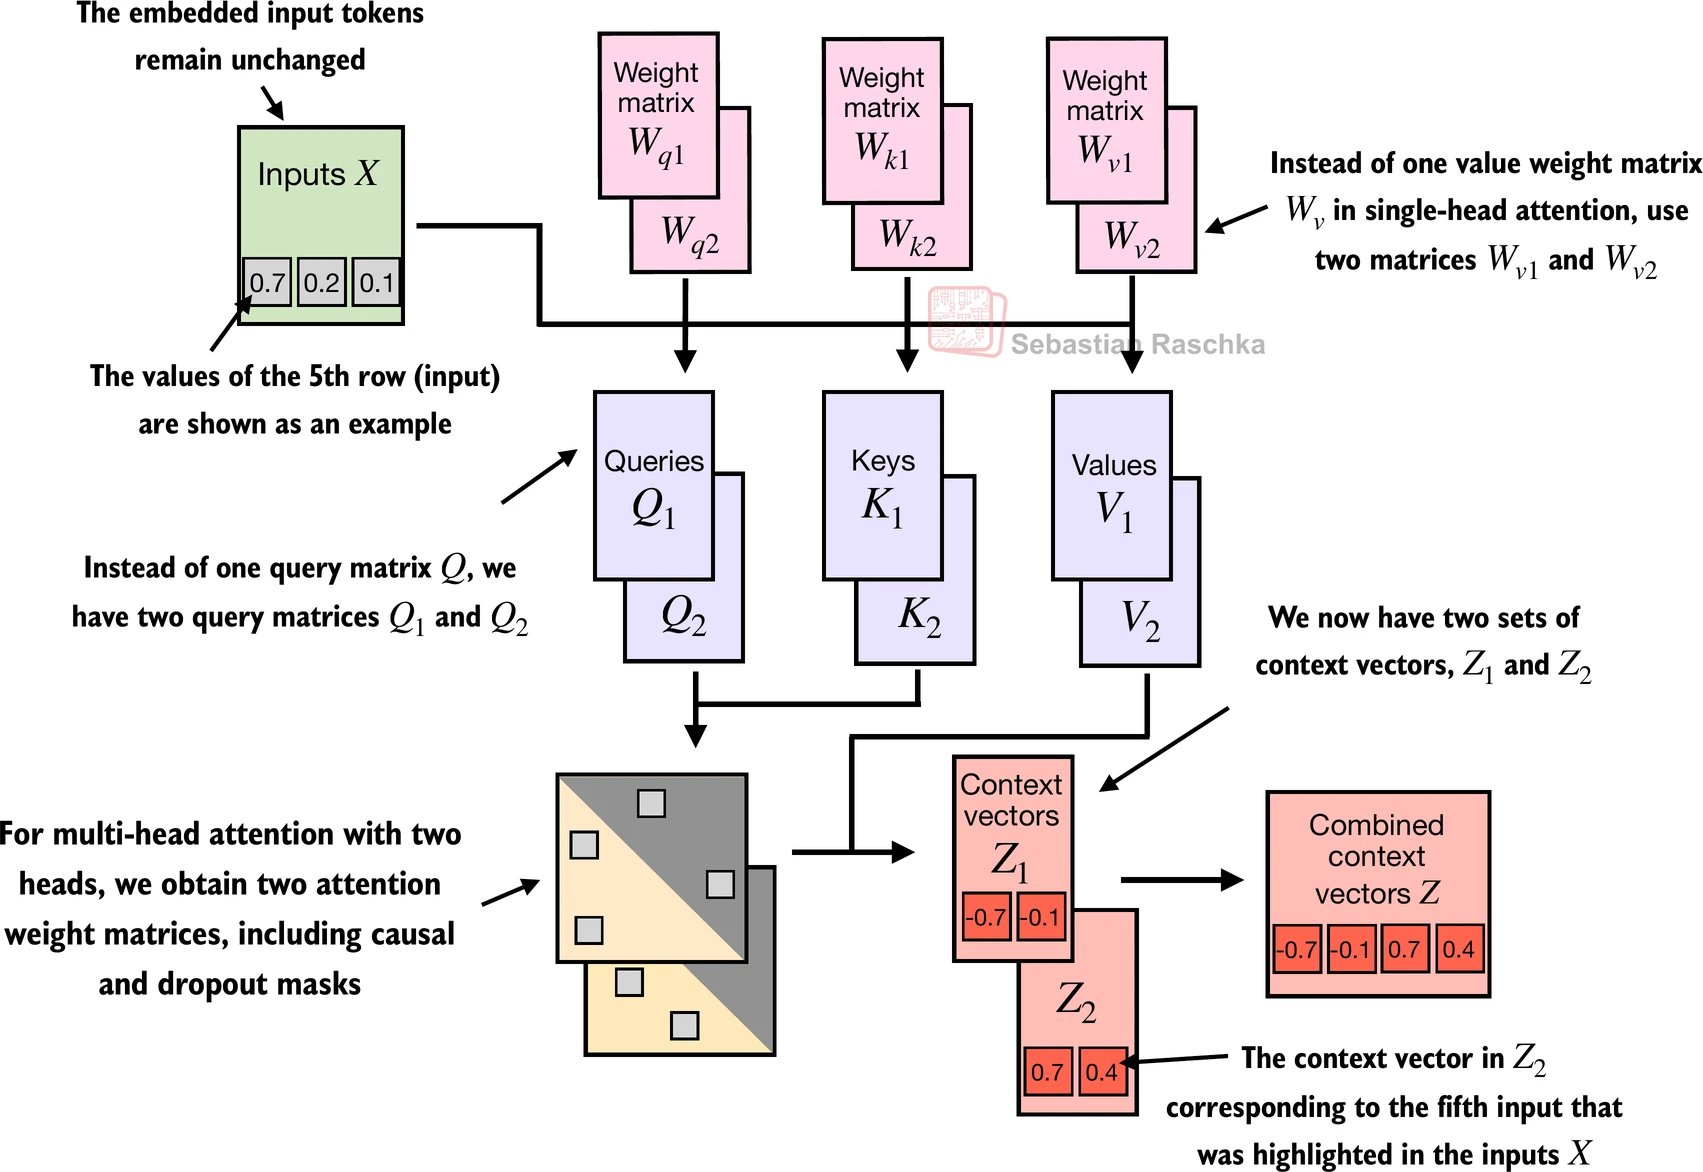

In [24]:
# Raw implementation stacking multiple CausalAttention modules.

class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # create list of module based on CausalAttention class
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        # Simply concatenate the outputs from each head along the last dimension
        return torch.cat([head(x) for head in self.heads], dim=-1) # SEQUENTIAL CONCATENATION <= IT IS A BOTTLECK

In [25]:
torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


###### note: In the implementation above, the embedding dimension is 4, because choosing d_out=2 as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4 (d_out * num_heads)

#### Multi-head attention with weight splits

This is a sophisticated implementation. The class will be able to splits the input into multiple heads by reshaping the projected query, key and value tensors and then combines the results from these heads after computing attention.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        ''' The MultiHeadAttention class allows us to control the output head dimension directly via d_out; 
        this means, if we set d_out = 2, the output head dimension will be 2, regardless of the number of heads. '''
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # This is simply a linear transformation that doesn't change the dimensions. 
        # It's a standard convention to use such a projection layer in LLM implementation, but it's not strictly necessary 
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # As in `CausalAttention`, for inputs where `num_tokens` exceeds `context_length`, 
        # this will result in errors in the mask creation further below. 
        # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs  
        # do not exceed `context_length` before reaching this forward method.

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        ##################################################################################################################
        '''
        In this implementation we are initilize one larger weight matrix W_q, W_k, W_v for each of the queries, keys and values respectively.
        Performing only one matrix multiplication with the input to obtain a query matrix, key matrix and value matrix.
        Then, splitting these matrices into multiple heads by reshaping them.

        To perform the splitting, we reshape the last dimension of the query, key, and value matrices from d_out to (num_heads, head_dim), where head_dim = d_out / num_heads.
        This effectively creates multiple "heads" of attention, each with its own set of query, key, and value vectors.
        '''

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        ''' This is crucial to for correctly aligning the queries, keys, and values across the different heads and performing batched matrix multiplications efficiently.'''
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        ##################################################################################################################

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec


In [27]:
torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


##### Explanation about the maths computations

try to explain the execution of *attn_scores = queries @ keys.transpose(2,3)*

In [ ]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

# a shape: (batch, num_heads, num_tokens, head_dim)
# b = batch size (1 here)
# num_heads = number of attention heads (2 here)
# num_tokens = sequence length per head (3 here)
# head_dim = dimensionality of each head vector (4 here)
#
# a.transpose(2, 3) swaps the last two dimensions:
#  (b, num_heads, num_tokens, head_dim) -> (b, num_heads, head_dim, num_tokens)
# This produces, for each (batch, head), the transposed key matrix (head_dim x num_tokens).
#
# When using the @ operator on tensors with rank > 2, PyTorch performs batched matrix
# multiplication over the last two dimensions while broadcasting/iterating over the
# leading dimensions (here batch and head). Therefore:
#  queries @ keys.transpose(2,3) performs, for each (batch, head):
#    (num_tokens x head_dim) @ (head_dim x num_tokens) -> (num_tokens x num_tokens)
# The overall result shape is (b, num_heads, num_tokens, num_tokens): attention scores
# (query vs key) computed independently for each head and batch.
#
# The following batched operation is equivalent to looping over heads and batches
# and computing head_matrix @ head_matrix.T for each head, but is vectorized and much faster.

print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In [ ]:
# Extended (non-batched) form demonstrating the equivalence:
# extract first head: shape (num_tokens, head_dim)
first_head = a[0, 0, :, :]
# compute (num_tokens x head_dim) @ (head_dim x num_tokens) -> (num_tokens x num_tokens)
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])
